In [1]:
# import libraries

import os
import json
from typing import Dict, List
import openai
from tqdm import tqdm
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import random

# Load environment variables - openai api key
load_dotenv()
client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

In [2]:
# JSON schema for GPT output

class Speech(BaseModel):
    speech_id: str
    emotional_intensity: int = Field(ge=1, le=5)  # Ensure value between 1 and 5
    political_spectrum: int = Field(ge=1, le=5)   # Ensure value between 1 and 5

class Speeches(BaseModel):
    speeches: List[Speech]

In [3]:
def read_speech_file(file_path: str) -> Dict[str, str]:
    """
    Reads a speech file and returns a dictionary mapping speech_ids to speeches.
    Only includes speeches with more than 35 words and less than 400 words.
    Handles and logs problematic lines without stopping the process.

    Args:
        file_path (str): Path to the speech file

    Returns:
        Dict[str, str]: A dictionary mapping speech_ids to
    """
    speeches = {}
    with open(file_path, 'r', encoding='utf-8', errors='replace') as file:
        # Skip header line
        next(file)
        for line_number, line in enumerate(file, start=2):  # Start at 2 to account for header
            try:
                cleaned_line = line.replace('�', ' ')
                # Split on pipe character
                parts = line.strip().split('|')
                if len(parts) == 2:
                    speech_id, speech = parts
                    # Only add speech if it has more than 35 words and less than 400 words
                    word_count = len(speech.split())
                    if 35 < word_count < 400:
                        speeches[speech_id] = speech
            except Exception as e:
                # Log the problematic line and continue
                print(f"Error processing line {line_number}: {line.strip()}\nException: {e}")
    return speeches

In [4]:
def chunk_speeches(speeches: Dict[str, str], max_chunk_size: int = 20000) -> List[Dict[str, str]]:
    """
    Splits speeches into chunks while keeping individual speeches intact.

    Args:
        speeches (Dict[str, str]): A dictionary mapping speech_ids to speeches
        max_chunk_size (int): The maximum size of each chunk in characters

    Returns:
        List[Dict[str, str]]: A list of dictionaries, each containing a chunk of speeches.
            The sum of length (in characters) of speeches in each chunk will be less than
            or equal to max_chunk_size.
    """
    chunks = []
    current_chunk = {}
    current_size = 0
    
    for speech_id, speech in speeches.items():
        speech_size = len(speech)
        # If adding this speech would exceed max size and we already have speeches,
        # start a new chunk
        if current_size + speech_size > max_chunk_size and current_chunk:
            chunks.append(current_chunk)
            current_chunk = {}
            current_size = 0
        
        current_chunk[speech_id] = speech
        current_size += speech_size
    
    # Add the last chunk if it's not empty
    if current_chunk:
        chunks.append(current_chunk)
    
    return chunks

In [5]:
def analyze_speeches(speeches: Dict[str, str]):
    """
    Uses OpenAI's API to analyze emotional intensity and political spectrum of speeches.

    Args:
        speeches (Dict[str, str]): A dictionary mapping speech_ids to speeches

    Returns:
        GPT Json formatted response according to prompt
    """
    # Prepare the speeches for analysis
    speeches_text = "\n\n".join([f"Speech ID: {id}\nContent: {text}" for id, text in speeches.items()])
    
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "system",
                    "content": """
                    Analyze each speech and rate it on two scales:

                    1. Emotional Intensity (1-5):
                    - 1: Neutral and technical; purely factual presentation with minimal personal expression
                    - 2: Mild emotional content; professional tone with clear stance and moderate conviction
                    - 3: Moderate emotional engagement; balanced but passionate delivery
                    - 4: Strong emotional content; powerful rhetoric and clear passion
                    - 5: Extremely emotional; intense passion, dramatic language, and strong calls to action

                    2. Political Spectrum (1-5):
                    - 1: Strongly Progressive (major reforms, significant system change, strong left policies)
                    - 2: Moderately Progressive (incremental changes, center-left policies)
                    - 3: Centrist (balance of progressive and traditional views)
                    - 4: Moderately Conservative (traditional values, center-right policies)
                    - 5: Strongly Conservative (emphasis on traditional values, major system preservation)

                    Consider factors like:
                    - Language and rhetoric used
                    - Policy positions expressed
                    - Values emphasized
                    - Economic and social views
                    - Treatment of traditional vs progressive values

                    Be objective and consistent in your ratings. Use the full range of the scale when appropriate - don't hesitate to use any number if it best matches the speech's content.
                    """
                },
                {
                    "role": "user",
                    "content": speeches_text
                }
            ],
            response_format={
                "type": "json_schema",
                "json_schema": {
                    "name":"_",
                    "schema": Speeches.model_json_schema()
                }
            },
            temperature=0.3,
            timeout=600  # 10 minute timeout
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error during API call: {str(e)}")
        raise

In [6]:
def process_speech_file(file_path: str, output_dir: str, max_chunks: int=None):
    """
    Process a speech file and save the results.

    Args:
        file_path (str): Path to the speech file
        output_dir (str): Directory to save the output file
        max_chunks (int, optional): Maximum number of chunks to process. Defaults to None.

    Returns:
        None
    """
    print(f"Processing file: {file_path}")
    # Read speeches
    speeches = read_speech_file(file_path)
    print(f"Found {len(speeches)} speeches")
    
    # Split into chunks
    chunks = chunk_speeches(speeches)
    print(f"Split into {len(chunks)} chunks")
    
    # Process each chunk and combine results
    all_results = {}

    # don't process chunks sequentially, instead loop through a random order
    # of indices to process the chunks in a random order
    chunk_indices = list(range(len(chunks)))
    random.shuffle(chunk_indices)
    chunk_count = 0
    for i in tqdm(chunk_indices, desc="Processing chunks"):
        chunk_count += 1
        chunk = chunks[i]
        try:
            # Get analysis for speeches in this chunk
            analysis_gpt_output = analyze_speeches(chunk)
            analysis_results = json.loads(analysis_gpt_output)
            
            # Combine speech text with analysis
            for speech in analysis_results["speeches"]:
                speech_id = speech["speech_id"]
                all_results[speech_id] = {
                    "speech": speeches[speech_id],
                    "emotional_intensity": speech["emotional_intensity"],
                    "political_spectrum": speech["political_spectrum"]
                }
            # print if chunk mod 10 == 0
            if (chunk_count) % 10 == 0:
                print(f"Successfully processed chunk {chunk_count}")

            if max_chunks and chunk_count >= max_chunks:
                break
                
        except Exception as e:
            print(f"Error processing chunk {i}: {str(e)}")
            continue
    
    # Save results
    output_file = os.path.join(output_dir, os.path.basename(file_path).replace('.txt', '_gpt_axis_labels.json'))
    os.makedirs(output_dir, exist_ok=True)
    with open(output_file, 'w') as f:
        json.dump(all_results, f, indent=2)
    print(f"\nResults saved to {output_file}")

In [7]:
def create_visualizations(emotional_df: pd.DataFrame, political_df: pd.DataFrame):
    """
    Create visualizations for the rating distributions.

    Args:
        emotional_df (pd.DataFrame): DataFrame with emotional intensity ratings
        political_df (pd.DataFrame): DataFrame with political spectrum ratings

    Returns:
        None
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot Emotional Intensity
    ax1.bar(emotional_df['Rating'], emotional_df['Percentage'])
    ax1.set_title('Distribution of Emotional Intensity Ratings')
    ax1.set_xlabel('Emotional Intensity Rating (1-5)')
    ax1.set_ylabel('Percentage of Speeches')
    ax1.set_xticks(range(1, 6))

    # Plot Political Spectrum
    ax2.bar(political_df['Rating'], political_df['Percentage'])
    ax2.set_title('Distribution of Political Spectrum Ratings')
    ax2.set_xlabel('Political Spectrum Rating (1=Far Left, 5=Far Right)')
    ax2.set_ylabel('Percentage of Speeches')
    ax2.set_xticks(range(1, 6))

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [8]:
def print_distribution(counts: dict, total: int):
    """
    Print the distribution of ratings in a formatted way.

    Args:
        counts (dict): A dictionary mapping ratings to counts
        total (int): Total number of speeches

    Returns:
        None
    """
    for rating in range(1, 6):
        count = counts.get(rating, 0)
        percentage = (count / total) * 100
        print(f"Rating {rating}: {count:4d} speeches ({percentage:5.1f}%)")

In [9]:
def analyze_ratings(input_dir: str, suffix:str='_gpt_axis_labels.json'):
    """
    Analyze the distribution of emotional intensity and political spectrum ratings
    from all JSON files in the input directory.

    Args:
        input_dir (str): Path to the directory containing JSON files
        suffix (str, optional): Suffix of JSON files to analyze. Defaults to '_gpt_axis_labels.json'.
    
    Returns:
        dict: A dictionary containing the counts of each rating for both metrics
            and the total number of speeches analyzed.
    """
    # Initialize counters for both metrics
    emotional_counts = defaultdict(int)
    political_counts = defaultdict(int)
    total_speeches = 0
    
    # Process each JSON file in the directory
    for filename in os.listdir(input_dir):
        if filename.endswith(suffix):
            file_path = os.path.join(input_dir, filename)
            with open(file_path, 'r') as f:
                data = json.load(f)
                
                # Count frequencies for each rating
                for speech_id, speech_data in data.items():
                    emotional_counts[speech_data['emotional_intensity']] += 1
                    political_counts[speech_data['political_spectrum']] += 1
                    total_speeches += 1
    
    # Convert to pandas DataFrames for easier analysis and visualization
    emotional_df = pd.DataFrame([
        {'Rating': rating, 'Count': count, 'Percentage': (count/total_speeches)*100}
        for rating, count in sorted(emotional_counts.items())
    ])
    
    political_df = pd.DataFrame([
        {'Rating': rating, 'Count': count, 'Percentage': (count/total_speeches)*100}
        for rating, count in sorted(political_counts.items())
    ])
    
    # Print summary statistics
    print(f"Total speeches analyzed: {total_speeches}\n")
    print("Emotional Intensity Distribution:")
    print_distribution(emotional_counts, total_speeches)
    print("\nPolitical Spectrum Distribution:")
    print_distribution(political_counts, total_speeches)
    
    # Create visualizations
    create_visualizations(emotional_df, political_df)
    
    return {
        'emotional_intensity': dict(emotional_counts),
        'political_spectrum': dict(political_counts),
        'total_speeches': total_speeches
    }

In [10]:
def process_speech_files(speech_files: List[str], input_dir: str, output_dir: str, max_chunks: int=None):
    """
    Process multiple speech files.

    Args:
        speech_files (List[str]): List of speech file names
        input_dir (str): Directory containing speech files
        output_dir (str): Directory to save output files
        max_chunks (int, optional): Maximum number of chunks to process. Defaults to None.

    Returns:
        None
    """
    for file_name in tqdm(speech_files, desc="Processing files"):
        file_path = os.path.join(input_dir, file_name)
        # get the file number to use as a suffix for the output file, e.g. speeches_105.txt -> 105
        file_num = file_name.split('_')[1].split('.')[0]
        # process the speech file
        process_speech_file(file_path, output_dir, max_chunks)
        print(f"analyzing ratings for {file_num+'_gpt_axis_labels.json'}")
        ratings_interim = analyze_ratings(output_dir, suffix=file_num+'_gpt_axis_labels.json')

In [11]:
def calculate_correlations(input_dir: str):
    """
    Calculate correlation between emotional intensity and political spectrum ratings.

    Args:
        input_dir (str): Directory containing JSON files with ratings.

    Returns:
        None
    """
    # Load ratings from all files in the form pairs of the form (emotional_intensity, political_spectrum)
    ratings_pairs = []
    
    for filename in os.listdir(input_dir):
        if filename.endswith('_gpt_axis_labels.json'):
            with open(os.path.join(input_dir, filename), 'r') as f:
                data = json.load(f)
                for speech_data in data.values():
                    ratings_pairs.append({
                        'emotional_intensity': speech_data['emotional_intensity'],
                        'political_spectrum': speech_data['political_spectrum']
                    })
    
    df = pd.DataFrame(ratings_pairs)
    # Calculate correlation
    correlation = df['emotional_intensity'].corr(df['political_spectrum'])
    
    print(f"\nCorrelation between Emotional Intensity and Political Spectrum: {correlation:.3f}")
    
    # Create correlation visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(df['political_spectrum'], df['emotional_intensity'], alpha=0.5)
    plt.title('Correlation: Emotional Intensity vs Political Spectrum')
    plt.xlabel('Political Spectrum Rating (1=Far Left, 5=Far Right)')
    plt.ylabel('Emotional Intensity Rating')
    plt.grid(True)
    plt.savefig('rating_correlation.png')
    plt.close()

Processing files:   0%|          | 0/2 [00:00<?, ?it/s]

Processing file: ../hein-daily/speeches_112.txt
Found 47745 speeches
Split into 2612 chunks


Successfully processed chunk 10


Error processing chunk 1057: '1120059081'


Error during API call: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Error processing chunk 671: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


Successfully processed chunk 20


Successfully processed chunk 30


Successfully processed chunk 40


Successfully processed chunk 50


Successfully processed chunk 60


Successfully processed chunk 70


Successfully processed chunk 80


Successfully processed chunk 90


Processing chunks:   4%|▍         | 99/2612 [05:13<2:12:38,  3.17s/it]

Successfully processed chunk 100

Results saved to outputs/speeches_112_gpt_axis_labels.json
analyzing ratings for 112_gpt_axis_labels.json
Total speeches analyzed: 1700

Emotional Intensity Distribution:
Rating 1:  298 speeches ( 17.5%)
Rating 2:  312 speeches ( 18.4%)
Rating 3:  573 speeches ( 33.7%)
Rating 4:  462 speeches ( 27.2%)
Rating 5:   55 speeches (  3.2%)

Political Spectrum Distribution:
Rating 1:  133 speeches (  7.8%)
Rating 2:  386 speeches ( 22.7%)
Rating 3:  891 speeches ( 52.4%)
Rating 4:  213 speeches ( 12.5%)
Rating 5:   77 speeches (  4.5%)


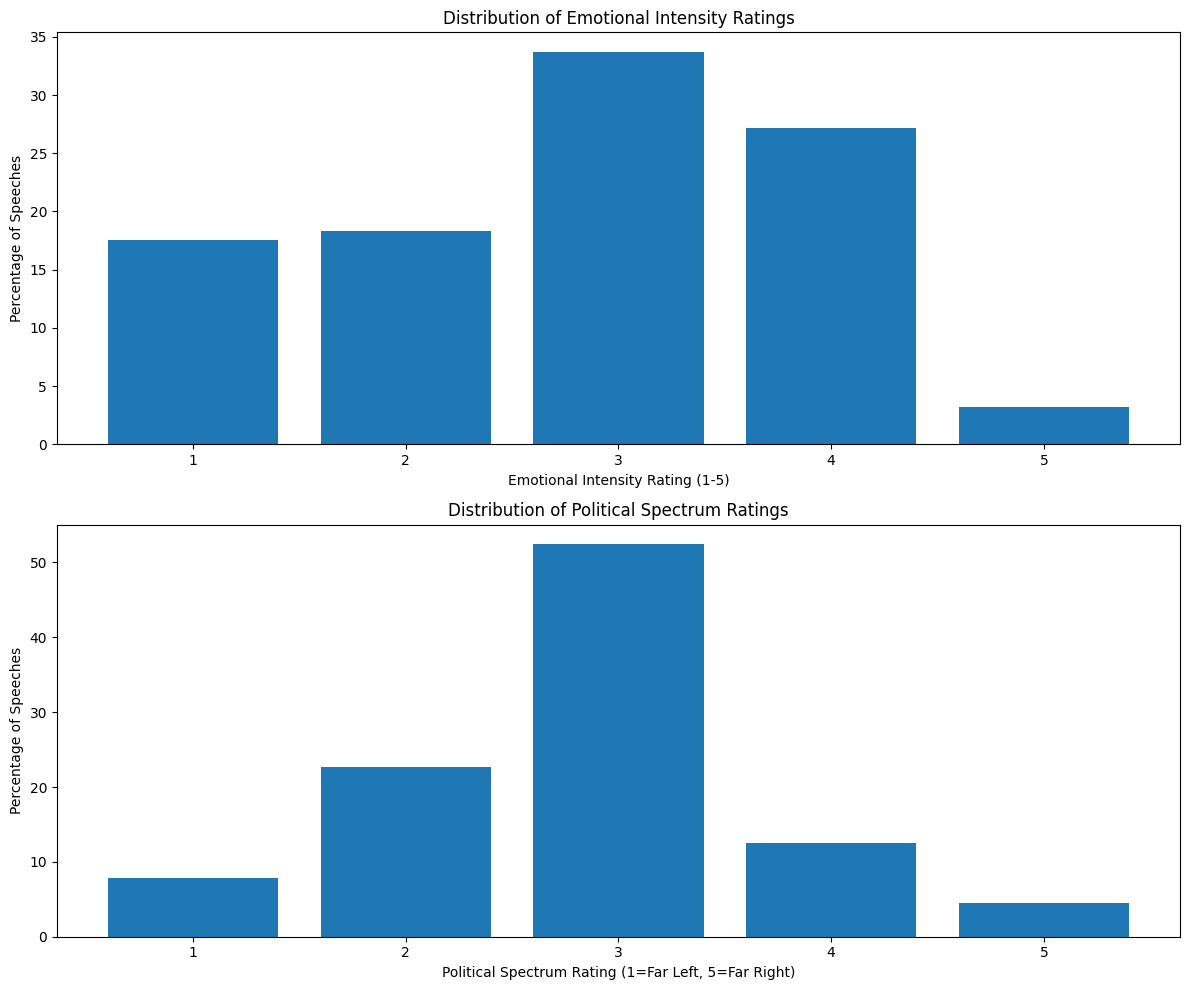

Processing files:  50%|█████     | 1/2 [05:15<05:15, 315.09s/it]

Processing file: ../hein-daily/speeches_113.txt
Found 42644 speeches
Split into 2330 chunks


Successfully processed chunk 10


Successfully processed chunk 20


Successfully processed chunk 30


Successfully processed chunk 40


Successfully processed chunk 50


Successfully processed chunk 60


Successfully processed chunk 70


Successfully processed chunk 80


Successfully processed chunk 90


Processing chunks:   4%|▍         | 99/2330 [05:43<2:08:54,  3.47s/it]

Successfully processed chunk 100

Results saved to outputs/speeches_113_gpt_axis_labels.json


analyzing ratings for 113_gpt_axis_labels.json
Total speeches analyzed: 1721

Emotional Intensity Distribution:
Rating 1:  306 speeches ( 17.8%)
Rating 2:  315 speeches ( 18.3%)
Rating 3:  568 speeches ( 33.0%)
Rating 4:  486 speeches ( 28.2%)
Rating 5:   46 speeches (  2.7%)

Political Spectrum Distribution:
Rating 1:   96 speeches (  5.6%)
Rating 2:  430 speeches ( 25.0%)
Rating 3: 1005 speeches ( 58.4%)
Rating 4:  146 speeches (  8.5%)
Rating 5:   44 speeches (  2.6%)


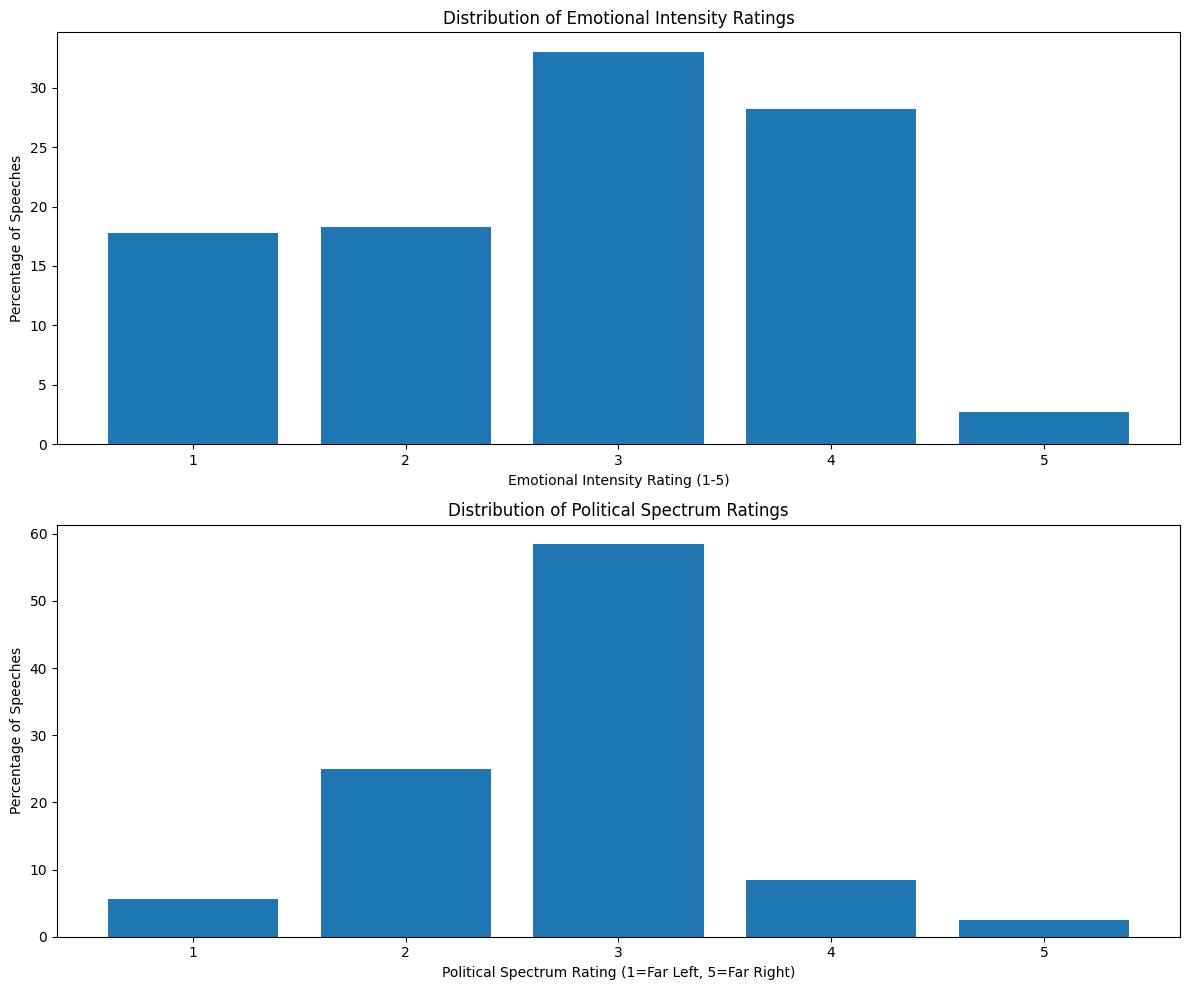

Processing files: 100%|██████████| 2/2 [10:59<00:00, 329.94s/it]


Total speeches analyzed: 80241

Emotional Intensity Distribution:
Rating 1: 13791 speeches ( 17.2%)
Rating 2: 30423 speeches ( 37.9%)
Rating 3: 24255 speeches ( 30.2%)
Rating 4: 11042 speeches ( 13.8%)
Rating 5:  730 speeches (  0.9%)

Political Spectrum Distribution:
Rating 1: 1676 speeches (  2.1%)
Rating 2: 13141 speeches ( 16.4%)
Rating 3: 58248 speeches ( 72.6%)
Rating 4: 5944 speeches (  7.4%)
Rating 5: 1232 speeches (  1.5%)


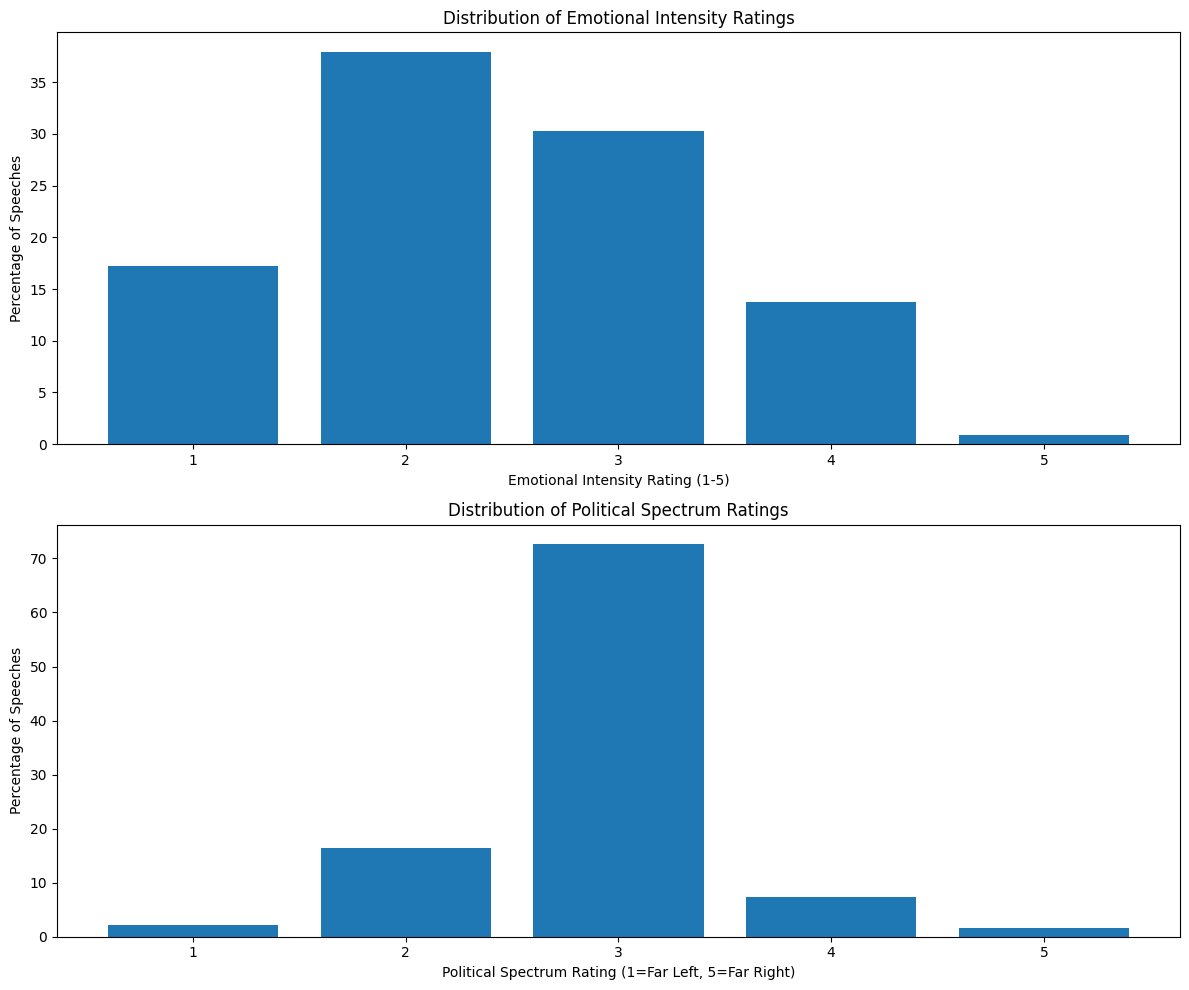


Correlation between Emotional Intensity and Political Spectrum: -0.280


In [12]:
if __name__ == "__main__":
    # first, do axis labeling for the congresses we have in hein-bound (79 to 111)
    input_dir = "../hein-bound"
    output_dir = "outputs"
    speech_files = [f for f in os.listdir(input_dir)
                    if f.startswith("speeches_") and f.endswith(".txt")
                    and f[9:-4].isdigit() and 79 <= int(f[9:-4]) <= 111]

    # sort the speech files
    speech_files.sort()
    process_speech_files(speech_files, input_dir, output_dir, max_chunks=100)

    # now, do axis labeling for congresses we only have in hein-daily (112 to 114)
    input_dir = "../hein-daily"
    speech_files = [f for f in os.listdir(input_dir) 
                    if f.startswith("speeches_") and f.endswith(".txt") 
                    and f[9:-4].isdigit() and 112 <= int(f[9:-4]) <= 114]
    speech_files.sort()
    process_speech_files(speech_files, input_dir, output_dir, max_chunks=100)

    # axis gpt output analysis:
    input_dir_axis = "outputs"  # Directory containing the analysis JSON files
    
    # Analyze distributions
    results = analyze_ratings(input_dir_axis)
    
    # Calculate correlations
    calculate_correlations(input_dir_axis)